In [121]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import h5py

import astropy.units as u
from astropy.io import fits
from astropy.modeling import models, fitting
from astropy.nddata import StdDevUncertainty
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.fitting import fit_generic_continuum, fit_continuum, fit_lines
from specutils.analysis import centroid, line_flux, equivalent_width
from IPython.display import Image, display
from astroML.datasets.tools.sdss_fits import log_OIII_Hb_NII

from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt

from caterpillar import catalog

import sys
sys.path.insert(1, '/home/ksf293/anomalies-GAN-HSC/analysis')
import plotter
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib
from matplotlib import pylab

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 100 #200
params = {'legend.fontsize': 'large',
          'figure.figsize': (6, 4),
         'axes.labelsize': 'large',
         'axes.titlesize': 'large',
         'xtick.labelsize': 'large',
         'ytick.labelsize': 'large'}
pylab.rcParams.update(params)

In [3]:
base_dir = '/scratch/ksf293/anomalies'
#plot_dir = '/home/ksf293/anomalies-GAN-HSC/plots/plots_2021-04-01'
plot_dir = '/home/ksf293/anomalies-GAN-HSC/papers/paper_main/images'

## Load in spectrum

In [4]:
hdul = fits.open('../data/keck_data/bluedot/bluedot_coadd_det3.fits')

In [116]:
info = hdul.info()
hdr = hdul[0].header
data = hdul[1].data
print(data.names)
w = data['wave']
f = data['flux']
err = 1/np.sqrt(data['ivar'])

Filename: ../data/keck_data/bluedot/bluedot_coadd_det3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1                1 BinTableHDU     30   4092R x 4C   ['1D', '1D', '1D', '1K']   
['wave', 'flux', 'ivar', 'mask']


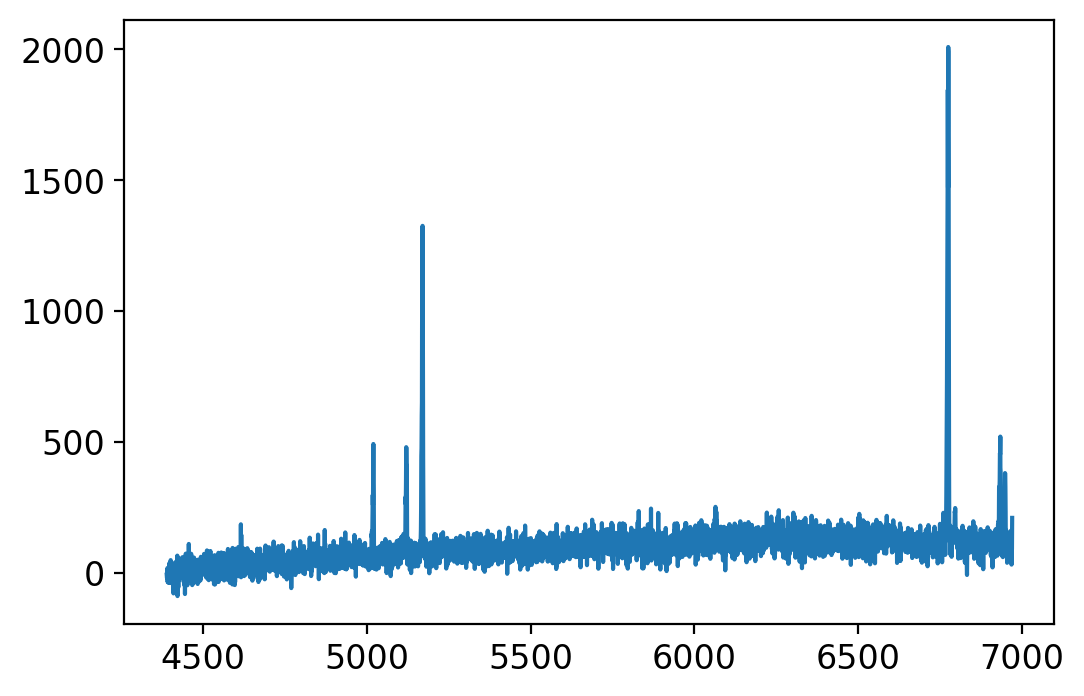

In [6]:
plt.plot(w, f)

In [7]:
#from here http://classic.sdss.org/dr6/algorithms/linestable.html
line_dict = {r'H$\alpha$':6564.61, r'H$\beta$':4862.68, 'OIIIa':4364.436, 'OIIIb':4932.603, 'OIIIc':4960.295, 
             'OIIId':5008.240, 'NIIa':6549.86, 'NIIb':6585.27, 'SIIa':6718.29, 'SIIb':6732.67}

### Shift spectrum based on redshift

In [122]:
# Redshift via fits by X Prochaska
# (https://docs.google.com/document/d/10n5E8VDJrd3xSTXbU-RvsNgrjl6vjcoLdYiE35Fg0tw/edit)
# also make cut above 4800
z=0.03221 
wave = w*u.AA / (1+z)
wave_mask = wave>4750*u.AA
wave = wave[wave_mask]
flux = u.Quantity(f[wave_mask]) # flux has unknown dimensions, but we still need to make it a quantity
uncertainty = StdDevUncertainty(err[wave_mask])
spec_norm = Spectrum1D(spectral_axis=wave, flux=flux, uncertainty=uncertainty, redshift=z) 

Text(0, 0.5, 'flux (arbitrary units)')

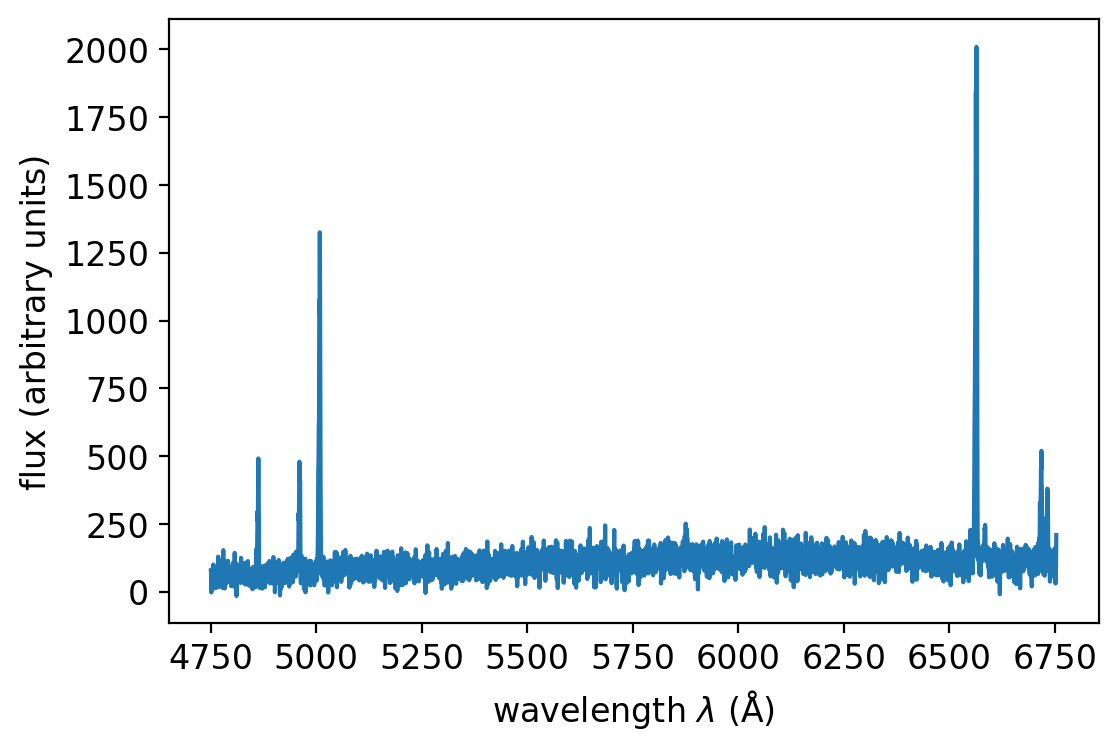

In [9]:
plt.plot(spec_norm.wavelength, spec_norm.flux)
xlabel = r'wavelength $\lambda$ ($\mathrm{\AA}$)'
plt.xlabel(xlabel)
ylabel = r'flux (arbitrary units)'
plt.ylabel(ylabel)

## Continuum & Double Gaussian Fitting

Select continuum regions for fitting

In [10]:
regions = [
            #(4820*u.AA, 4830*u.AA),
            #(4800*u.AA, 4855*u.AA), (4868*u.AA, 4950*u.AA), #Hbeta
            (4847*u.AA, 4855*u.AA), (4869*u.AA, 4879*u.AA), #Hbeta
            (4963*u.AA, 4995*u.AA), #OIIIc
            (5010*u.AA, 5100*u.AA), #OIIId
    
            (5300*u.AA, 5350*u.AA),
            (6510*u.AA, 6550*u.AA),
    
            (6510*u.AA, 6550*u.AA), (6571*u.AA, 6576*u.AA), #Halpha
            (6595*u.AA, 6650*u.AA), #NIIb
            (6650*u.AA, 6715*u.AA), (6721*u.AA, 6727*u.AA), #SIIa
            (6737*u.AA, 6750*u.AA), #SIIb
          ]

In [12]:
fit_dict = {}

In [13]:
#region = [4940* u.AA, 4990 * u.AA]
fitted_continuum = fit_continuum(spec_norm, window=regions)
y_fit_continuum = fitted_continuum(spec_norm.wavelength)

Check out fits around tricky areas & whole spectrum:

(6520.0, 6620.0)

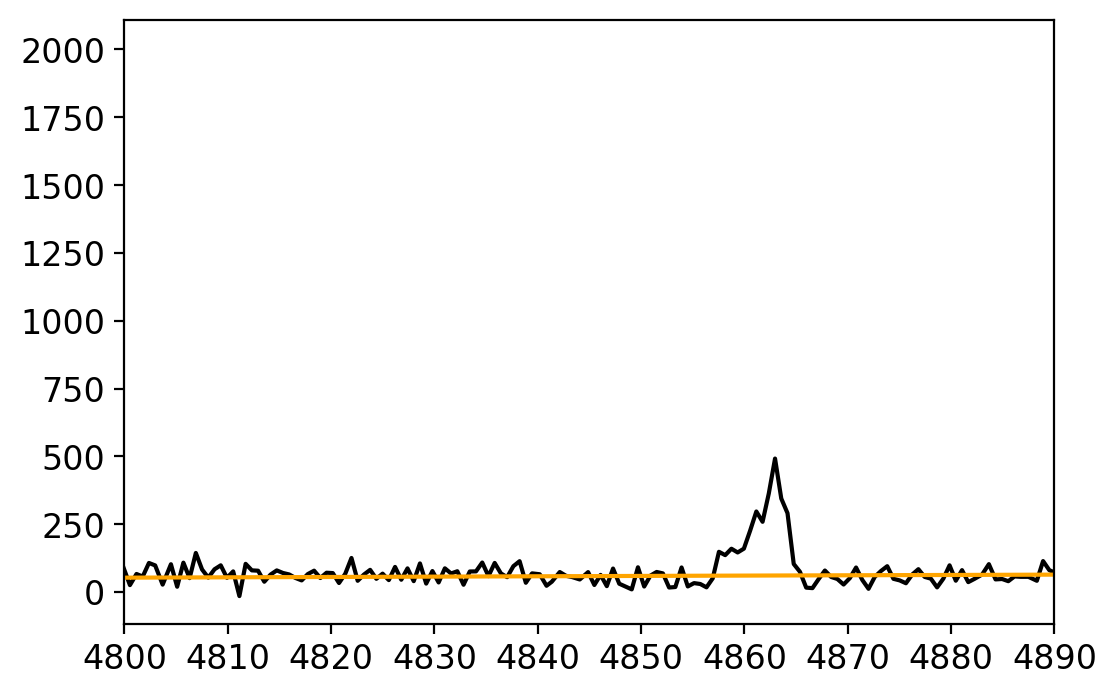

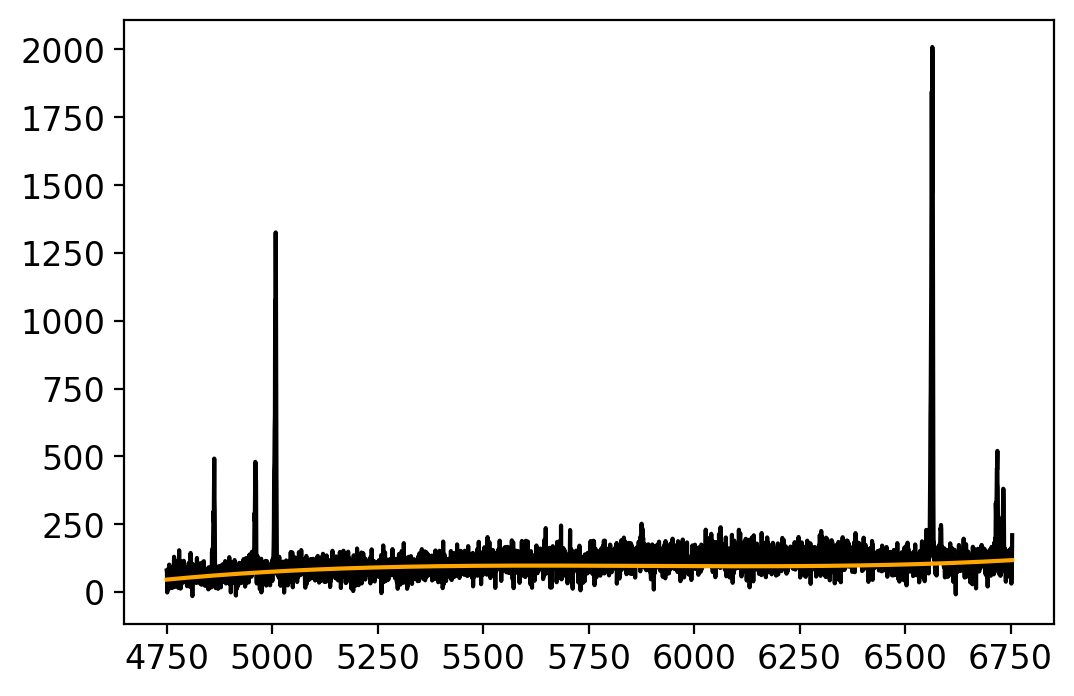

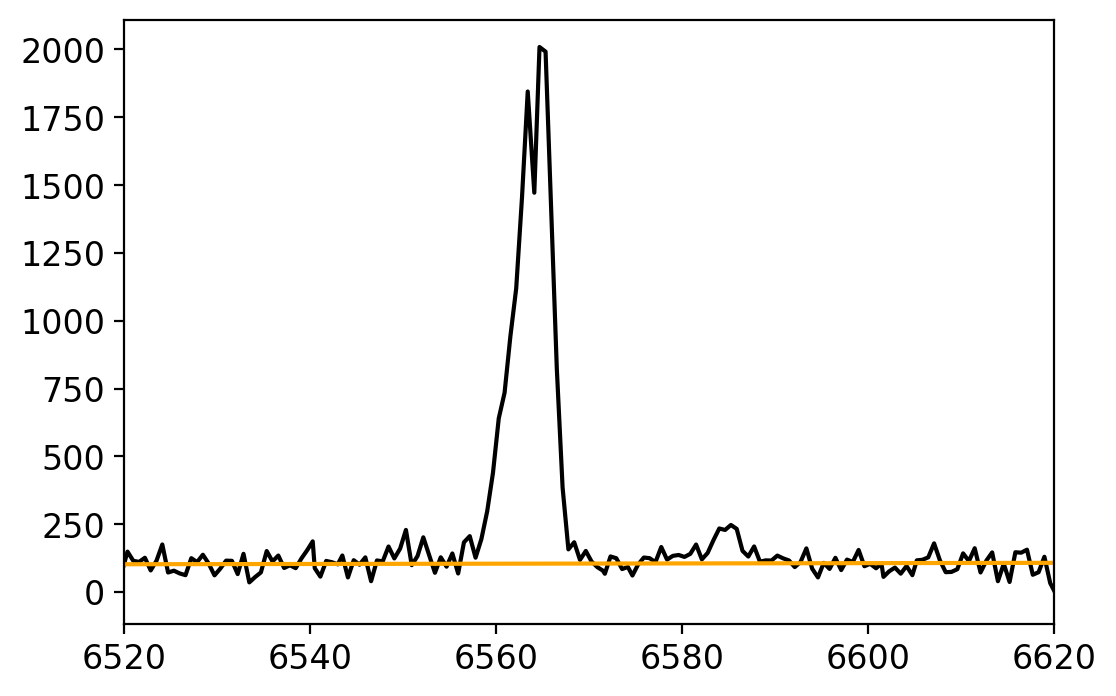

In [14]:
plt.figure()
plt.plot(spec_norm.wavelength, spec_norm.flux, color='black')
plt.plot(spec_norm.wavelength, y_fit_continuum, color='orange')
plt.xlim(4800, 4890)

plt.figure()
plt.plot(spec_norm.wavelength, spec_norm.flux, color='black')
plt.plot(spec_norm.wavelength, y_fit_continuum, color='orange')

plt.figure()
plt.plot(spec_norm.wavelength, spec_norm.flux, color='black')
plt.plot(spec_norm.wavelength, y_fit_continuum, color='orange')
plt.xlim(6520, 6620)

In [15]:
y_fit_continuum
spec_norm.wavelength[np.argmax(y_fit_continuum)]
y_fit_continuum[np.argmax(y_fit_continuum)-20:np.argmax(y_fit_continuum)+10]

<Quantity [116.29631947, 116.3495789 , 116.40290366, 116.45639395,
           116.5099351 , 116.56355202, 116.61726087, 116.67105026,
           116.72140137, 116.74081101, 116.79326401, 116.84735768,
           116.9015114 , 116.95544241, 116.99747044, 117.0499398 ,
           117.10433365, 117.15898844, 117.21359581, 117.26831157,
           117.32311685]>

In [16]:
# normalize by continuum, subtract 1 so centered at 0 (use spec_norm/spec_norm=1 for correct units)
spec_norm_cont = spec_norm / y_fit_continuum - spec_norm/spec_norm

In [140]:
spec_norm_cont.uncertainty = StdDevUncertainty(spec_norm.uncertainty.array / y_fit_continuum - 1)

### Fit double gaussians to each emission line

In [217]:
def double_gaussian_fit(spec, line_name, amp0, mean0, std0, amp1, mean1, std1,
                        exclude_regions=None, window=None, show_fig=False):
    #mean = line_dict[line_name]

    g1_init = models.Gaussian1D(amplitude=amp0, mean=mean0*u.Angstrom, stddev=std0*u.Angstrom)
    g2_init = models.Gaussian1D(amplitude=amp1, mean=mean1*u.Angstrom, stddev=std1*u.Angstrom)

    kwargs = {'maxiter':1000}
    fitter = fitting.LevMarLSQFitter()
    g12_fit = fit_lines(spec, g1_init+g2_init, window=window, exclude_regions=exclude_regions,
                        fitter=fitter, weights=spec.uncertainty.array, **kwargs)
    print(fitter.fit_info['message'])
    print(g12_fit.param_names)
    
    #print(fitter.fit_info['param_cov'])
    cov_diag = np.diag(fitter.fit_info['param_cov'])
    err = np.sqrt(cov_diag)
    print(err)
    
    y_fit = g12_fit(spec.wavelength)
    g1 = models.Gaussian1D(g12_fit.amplitude_0, g12_fit.mean_0, g12_fit.stddev_0)
    g2 = models.Gaussian1D(g12_fit.amplitude_1, g12_fit.mean_1, g12_fit.stddev_1)

    y1_fit = g1(spec.wavelength.value)
    y2_fit = g2(spec.wavelength.value)

    plt.figure(figsize=(4,3))
    plt.plot(spec.wavelength, spec.flux, color='k')
    plt.plot(spec.wavelength, y_fit, color='steelblue')
    plt.plot(spec.wavelength, y1_fit, color='orchid', ls='-')
    plt.plot(spec.wavelength, y2_fit, color='maroon', ls='-')
    
    plt.plot(spec.wavelength, spec.flux+spec.uncertainty.array, color='grey', ls='-', lw=0.5)
    plt.plot(spec.wavelength, spec.flux-spec.uncertainty.array, color='grey', ls='-', lw=0.5)


    # errors
    g1_hi = models.Gaussian1D(g12_fit.amplitude_0+err[0], g12_fit.mean_0-err[1], g12_fit.stddev_0+err[2])
    g2_hi = models.Gaussian1D(g12_fit.amplitude_1+err[3], g12_fit.mean_1+err[4], g12_fit.stddev_1+err[5])
    y1_fit_hi = g1_hi(spec.wavelength.value)
    y2_fit_hi = g2_hi(spec.wavelength.value)

    plt.plot(spec.wavelength, y1_fit_hi, color='orchid', ls=':')
    plt.plot(spec.wavelength, y2_fit_hi, color='maroon', ls=':')
    
    # formatting
    xmin, xmax = line_dict[line_name]-20, line_dict[line_name]+20
    plt.xlim(xmin, xmax)
    plt.ylim(-2, 20)
    
    return g12_fit, g1, g2, plt.gca()

The relative error between two consecutive iterates is at most 0.000000
('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1')
[3.87975449 5.9157335  1.87105617 6.2556969  0.41177086 0.69997542]
<QuantityModel CompoundModel(amplitude_0=1.92945019, mean_0=4958.68065407, stddev_0=1.84474356, amplitude_1=5.02239348, mean_1=4960.90313427, stddev_1=1.07525269), input_units=Angstrom, return_units=>


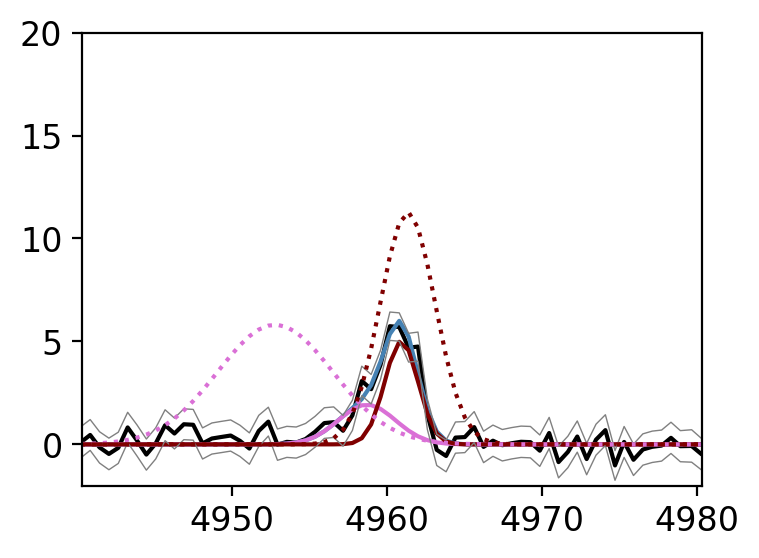

In [207]:
line_name = 'OIIIc'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 
                                          amp0=2, mean0=4959, std0=2, amp1=5, mean1=4962, std1=1, 
                                          show_fig=True)
print(g12_fit)
fit_dict[line_name] = [g12_fit, g1, g2]

The relative error between two consecutive iterates is at most 0.000000
('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1')
[3.48586308 1.44334404 0.46562603 3.55985635 0.36303672 0.26519335]
<QuantityModel CompoundModel(amplitude_0=5.86031643, mean_0=5006.16956492, stddev_0=1.46730657, amplitude_1=14.22029911, mean_1=5008.69300895, stddev_1=1.1091003), input_units=Angstrom, return_units=>


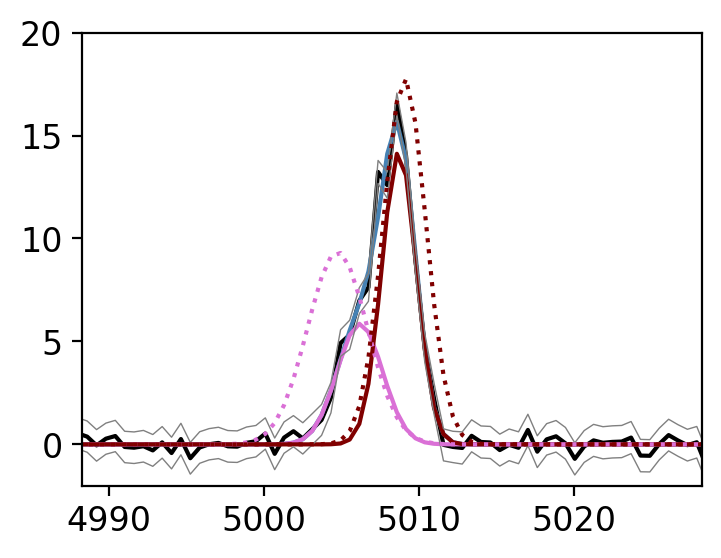

In [154]:
line_name = 'OIIId'
# g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 
#                                           amp0=5, mean0=5005, std0=3, amp1=9, mean1=5009, std1=3, 
#                                           show_fig=True)
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 
                                          amp0=5, mean0=5005, std0=3, amp1=9, mean1=5009, std1=3, 
                                          show_fig=True)
print(g12_fit)
fit_dict[line_name] = [g12_fit, g1, g2]

In [247]:
line_name = r'H$\alpha$'
# g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 
#                                           amp0=2, mean0=6561, std0=5, amp1=13, mean1=6566, std1=2, 
#                                           show_fig=True)
window = [SpectralRegion(6556*u.AA,6564*u.AA), SpectralRegion(6564*u.AA,6572*u.AA)]
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 
                                          amp0=2, mean0=6561, std0=5, amp1=13, mean1=6566, std1=2, 
                                          show_fig=True, window=window)
                                         #exclude_regions=[SpectralRegion(6563*u.AA,6564*u.AA)] )
print(g12_fit)
fit_dict[line_name] = [g12_fit, g1, g2]

Number of calls to function has reached maxfev = 1000.
('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1')


ValueError: Input must be 1- or 2-d.

The relative error between two consecutive iterates is at most 0.000000
('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1')
[1.48066032 2.10992184 0.9715107  2.98426788 0.23141213 0.3934238 ]


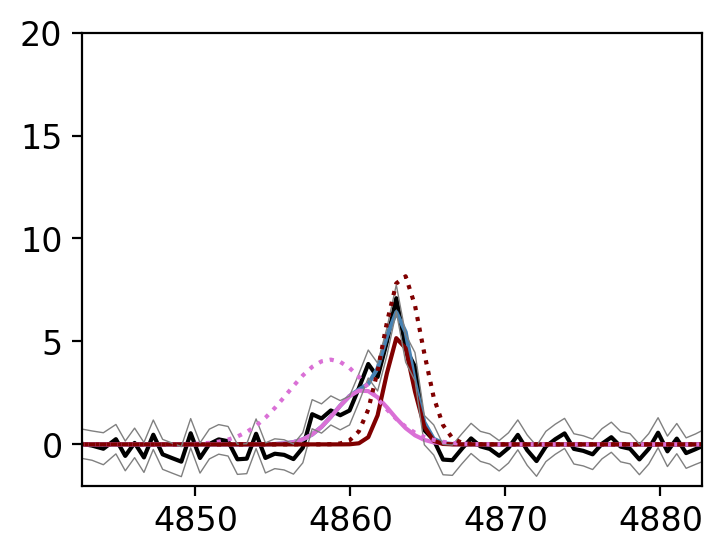

In [248]:
line_name = r'H$\beta$'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name,
                                          amp0=2, mean0=4859, std0=1, amp1=5, mean1=4863, std1=2, 
                                          show_fig=True)
fit_dict[line_name] = [g12_fit, g1, g2]

Both actual and predicted relative reductions in the sum of squares
  are at most 0.000000 and the relative error between two consecutive iterates is at 
  most 0.000000
('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1')
[0.44379603 5.3844808  4.71756727 0.58537852 1.10849802 1.10474505]
<QuantityModel CompoundModel(amplitude_0=0.34339605, mean_0=6579.77324725, stddev_0=2.17515985, amplitude_1=1.3145468, mean_1=6584.91686431, stddev_1=1.36284733), input_units=Angstrom, return_units=>


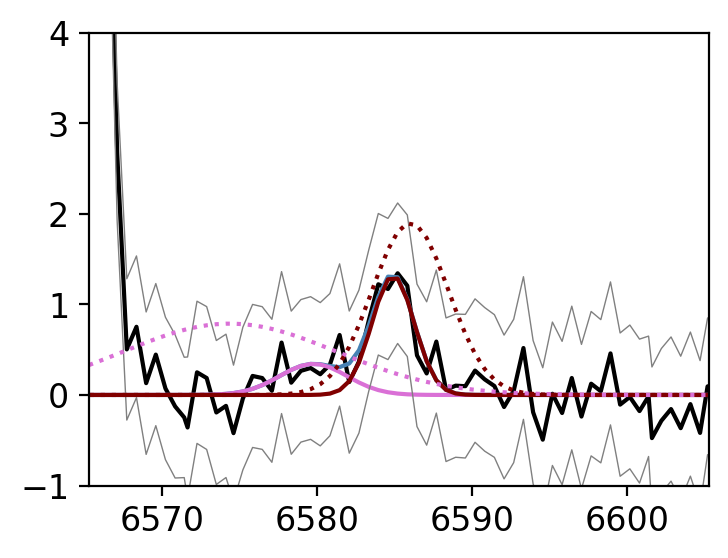

In [170]:
line_name = 'NIIb'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 
                                          amp0=0.5, mean0=6581, std0=1, amp1=1.5, mean1=6585, std1=1, 
                                          show_fig=True)
print(g12_fit)
ax.set_ylim(-1, 4)
fit_dict[line_name] = [g12_fit, g1, g2]

The relative error between two consecutive iterates is at most 0.000000
('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1')
[2.04179291 2.83725207 1.00639668 0.65450373 1.27625487 1.10110689]
<QuantityModel CompoundModel(amplitude_0=1.52454768, mean_0=6715.5530163, stddev_0=1.21556654, amplitude_1=3.2079634, mean_1=6718.5069088, stddev_1=1.15470612), input_units=Angstrom, return_units=>


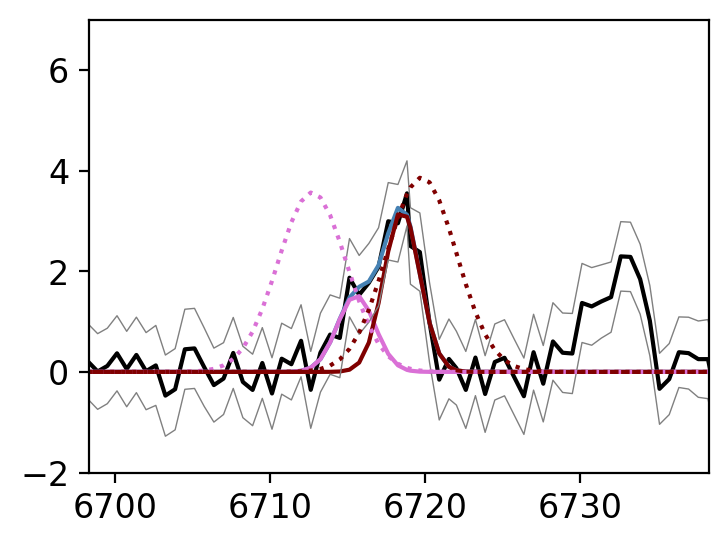

In [171]:
line_name = 'SIIa'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 
                                          amp0=1, mean0=6714, std0=1, amp1=3, mean1=6717, std1=2, 
                                          show_fig=True)
fit_dict[line_name] = [g12_fit, g1, g2]
ax.set_ylim(-2, 7)
print(g12_fit)

The relative error between two consecutive iterates is at most 0.000000
('amplitude_0', 'mean_0', 'stddev_0', 'amplitude_1', 'mean_1', 'stddev_1')
[1.87156257 3.42634689 1.2864042  1.13236408 1.42400485 1.27095222]
<QuantityModel CompoundModel(amplitude_0=1.29578702, mean_0=6730.76495229, stddev_0=1.18706639, amplitude_1=2.30862577, mean_1=6733.21595002, stddev_1=0.84827387), input_units=Angstrom, return_units=>


(-2.0, 7.0)

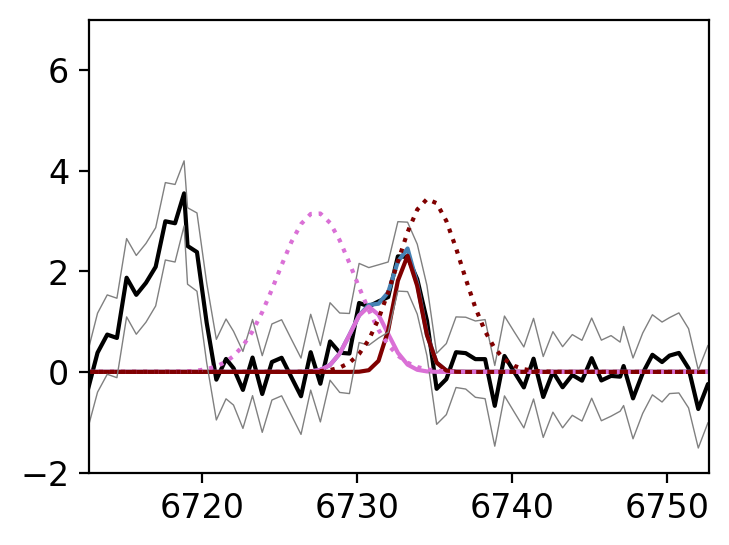

In [172]:
line_name = 'SIIb'
g12_fit, g1, g2, ax = double_gaussian_fit(spec_norm_cont, line_name, 
                                          amp0=1, mean0=6731, std0=1.2, amp1=2, mean1=6733, std1=1, 
                                          show_fig=True)
print(g12_fit)
fit_dict[line_name] = [g12_fit, g1, g2]
ax.set_ylim(-2, 7)


### Integrate double gaussian flux fits to get flux

In [24]:
def integrate_g12(g_fit, spec):
    mean = g_fit.mean_0
    xmin, xmax = mean - 20, mean + 20
    xs = np.linspace(xmin, xmax, 1000)
    y_fit = g_fit(xs*u.Angstrom)
    return np.trapz(y_fit, xs)

In [25]:
def integrate_g(g_fit, spec):
    mean = g_fit.mean
    xmin, xmax = mean - 20, mean + 20
    xs = np.linspace(xmin, xmax, 1000)
    y_fit = g_fit(xs)
    return np.trapz(y_fit, xs)

In [26]:
gflux_nII = integrate_g12(fit_dict['NIIb'][0], spec_norm_cont)
gflux_halpha = integrate_g12(fit_dict[r'H$\alpha$'][0], spec_norm_cont)
gflux_oIII = integrate_g12(fit_dict['OIIId'][0], spec_norm_cont)
gflux_hbeta = integrate_g12(fit_dict[r'H$\beta$'][0], spec_norm_cont)
gflux_sIIa = integrate_g12(fit_dict[r'SIIa'][0], spec_norm_cont)
gflux_sIIb = integrate_g12(fit_dict[r'SIIb'][0], spec_norm_cont)

In [27]:
print(gflux_nII)
print(gflux_halpha)
print(gflux_oIII)
print(gflux_hbeta)
print(gflux_sIIa)
print(gflux_sIIb)

6.371734936362357
88.11590851562949
61.79325579502026
23.08451868128773
13.996047169751371
8.814026304643365


In [28]:
gflux_nII_left = integrate_g(fit_dict['NIIb'][1], spec_norm_cont)
gflux_halpha_left = integrate_g(fit_dict[r'H$\alpha$'][1], spec_norm_cont)
gflux_oIII_left = integrate_g(fit_dict['OIIId'][1], spec_norm_cont)
gflux_hbeta_left = integrate_g(fit_dict[r'H$\beta$'][1], spec_norm_cont)
gflux_sIIa_left = integrate_g(fit_dict[r'SIIa'][1], spec_norm_cont)
gflux_sIIb_left = integrate_g(fit_dict[r'SIIb'][1], spec_norm_cont)

gflux_nII_right = integrate_g(fit_dict['NIIb'][2], spec_norm_cont)
gflux_halpha_right = integrate_g(fit_dict[r'H$\alpha$'][2], spec_norm_cont)
gflux_oIII_right = integrate_g(fit_dict['OIIId'][2], spec_norm_cont)
gflux_hbeta_right = integrate_g(fit_dict[r'H$\beta$'][2], spec_norm_cont)
gflux_sIIa_right = integrate_g(fit_dict[r'SIIa'][2], spec_norm_cont)
gflux_sIIb_right = integrate_g(fit_dict[r'SIIb'][2], spec_norm_cont)

### Plot fitted spectra

In [29]:
def plot_spectrum_zoom(ax, xmin, xmax):
    ax.step(spec_norm.wavelength, spec_norm.flux, color='black', lw=1.0) 

    y_fit_total = np.zeros(len(y_fit_continuum))
    for line in fit_dict:
        wline = line_dict[line]
        g12, g1, g2 = fit_dict[line]
        y_fit = g12(spec_norm.wavelength.value*u.Angstrom).value
        y_fit_total += y_fit

        wmin, wmax = wline-10, wline+10    
        region_mask = (wmin<spec_norm.wavelength.value) & (spec_norm.wavelength.value<wmax)
        wavelength_inregion = spec_norm.wavelength.value[region_mask]
        continuum_inregion = y_fit_continuum.value[region_mask]
        y_fit_g1 = g1(wavelength_inregion)
        y_fit_g2 = g2(wavelength_inregion)
        # un-normalize the fits to compare with original spectrum
        y_fit_g1_norm = continuum_inregion*(y_fit_g1 + 1)
        y_fit_g2_norm = continuum_inregion*(y_fit_g2 + 1)
        ax.plot(wavelength_inregion, y_fit_g1_norm, color='orchid', lw=1.3, zorder=1000)
        ax.plot(wavelength_inregion, y_fit_g2_norm, color='orchid', lw=1.3, zorder=1000)

        if xmin<wline<xmax:
            ax.text(wline-3, -1.8, line, {'color': 'dodgerblue', 'fontsize': 14},
                 horizontalalignment='right',
                 verticalalignment='top',
                 rotation=270)
        
    y_fit_total = y_fit_continuum.value*(y_fit_total + 1)

    ax.plot(spec_norm.wavelength, y_fit_total, color='dodgerblue', lw=1.5)
    ax.set_xlim(xmin, xmax)

<Figure size 600x400 with 0 Axes>

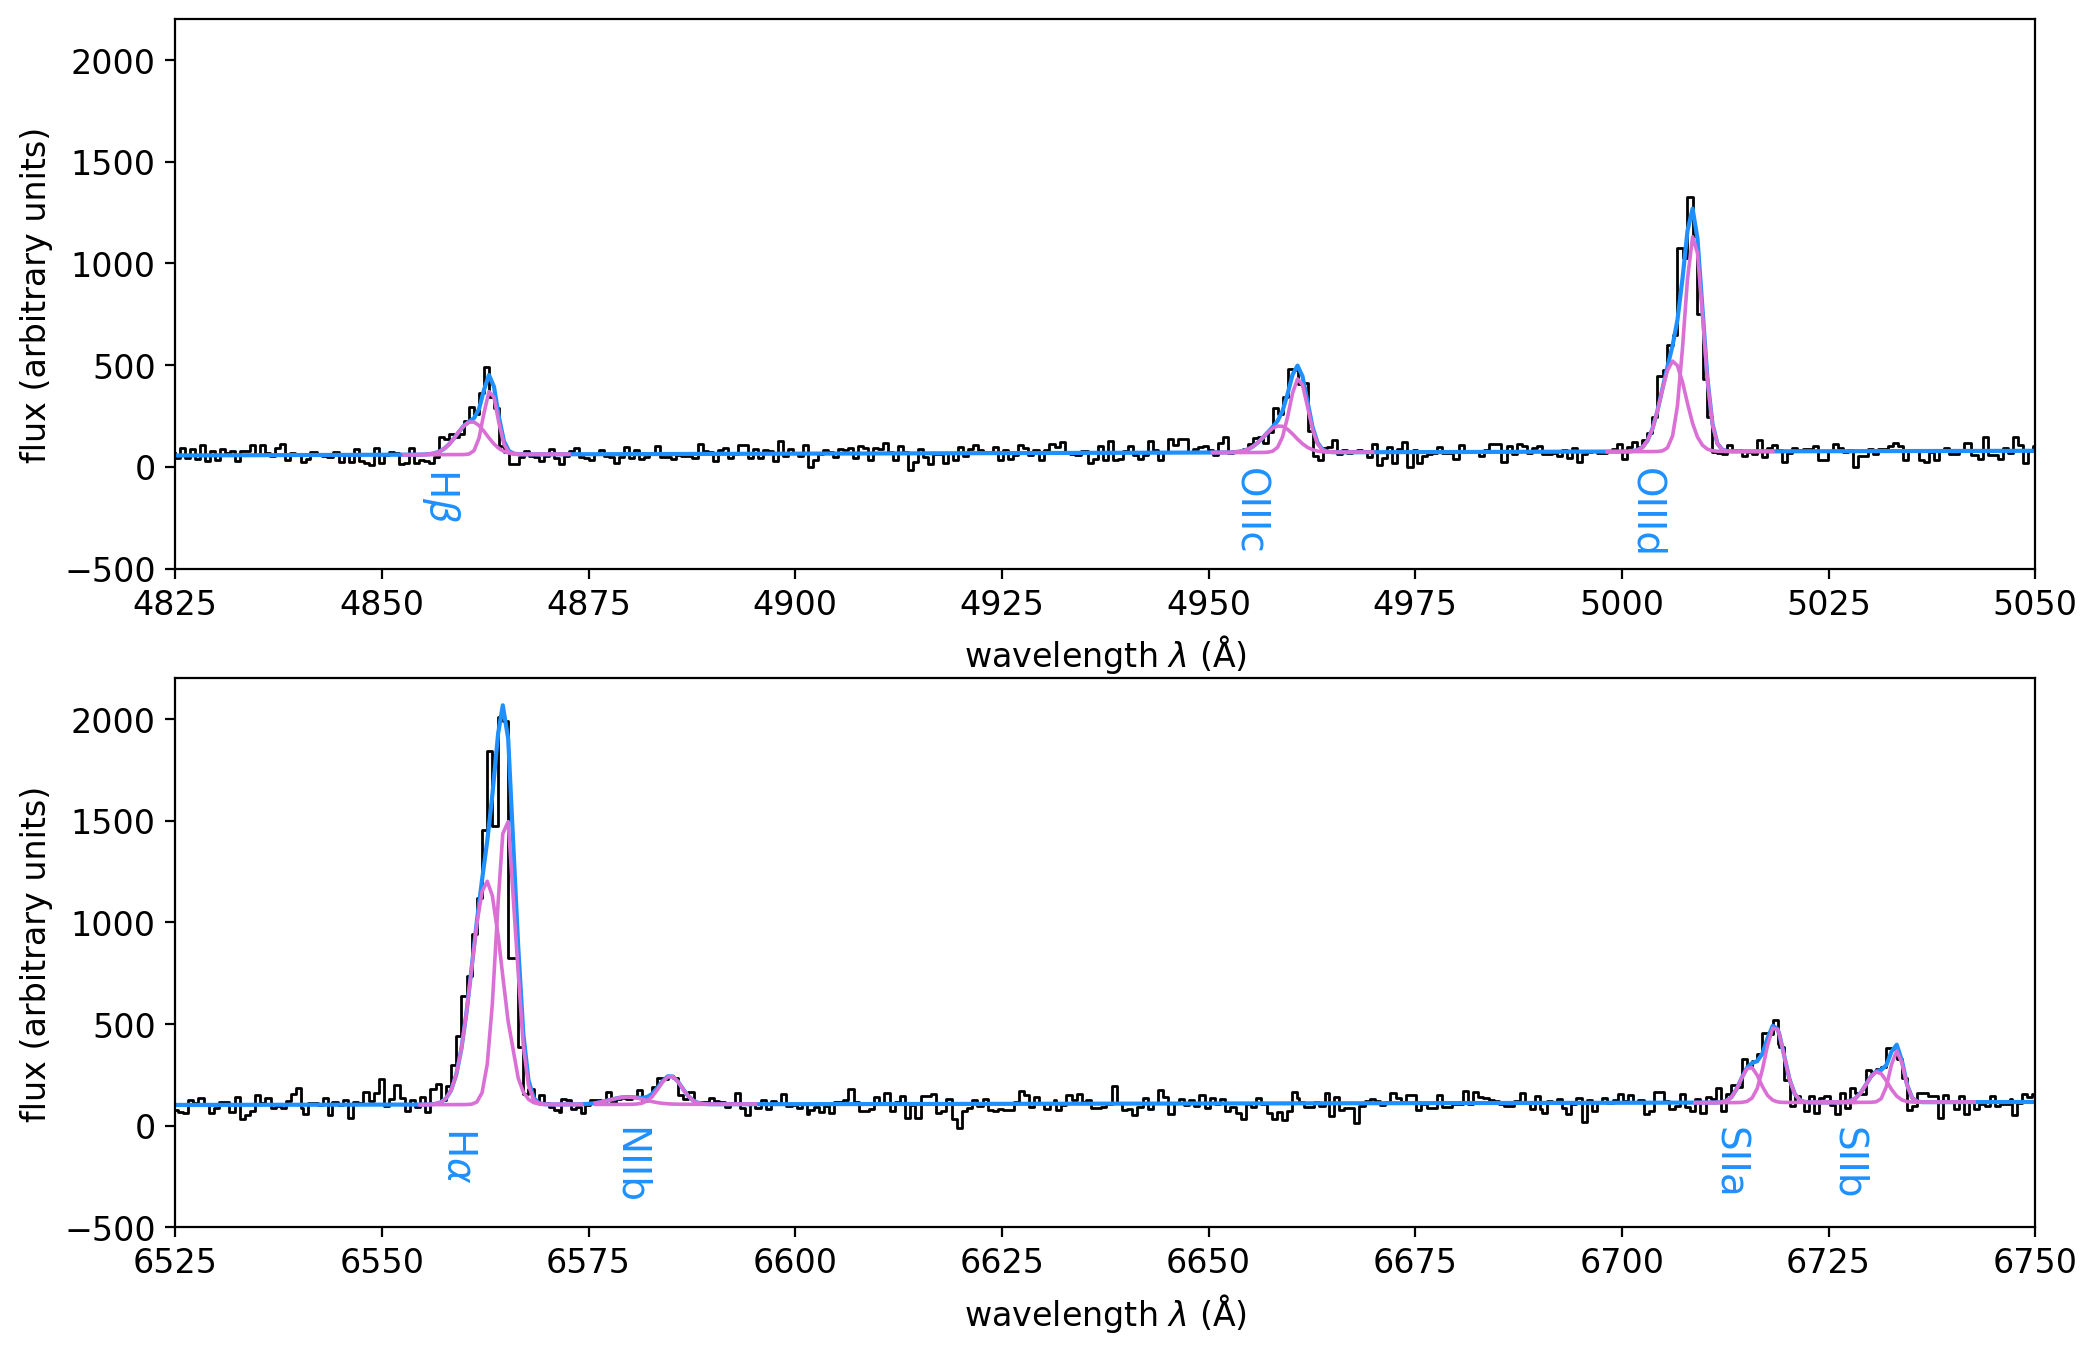

In [30]:
plt.figure()
fig, axarr = plt.subplots(2, 1, figsize=(12,8))
ax0, ax1 = axarr

plot_spectrum_zoom(ax0, 4825, 5050)
plot_spectrum_zoom(ax1, 6525, 6750)

# all labels
xlabel = r'wavelength $\lambda$ ($\mathrm{\AA}$)'
ax0.set_xlabel(xlabel)
ax1.set_xlabel(xlabel)
ylabel = r'flux (arbitrary units)'
ax0.set_ylabel(ylabel)
ax1.set_ylabel(ylabel)

ylim = (-500, 2200)
ax0.set_ylim(ylim)
ax1.set_ylim(ylim)

plt.savefig(f'{plot_dir}/spectra.png', bbox_inches='tight')

# BPT Diagram

Load SDSS matched sample of 0.02<z<0.05, S/N>3 for all BPT emission lines, b/a>0.5 (not edge on)

In [31]:
hdul_sdss = fits.open('../data/keck_data/SDSS_BPT_sample.fits')

In [32]:
info = hdul_sdss.info()
hdr_sdss = hdul_sdss[0].header
data_sdss = hdul_sdss[1].data

Filename: ../data/keck_data/SDSS_BPT_sample.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      16   (140275,)   uint8   
  1  Joined        1 BinTableHDU     54   35995R x 18C   [K, D, D, E, D, E, E, E, E, E, E, E, E, E, E, E, E, E]   


Measure BPT location SDSS objects

In [33]:
log_nII_ha_sdss = np.log10(data_sdss['NII_6584_FLUX']/data_sdss['H_ALPHA_FLUX'])
log_oIII_hb_sdss = np.log10(data_sdss['OIII_5007_FLUX']/data_sdss['H_BETA_FLUX'])

Measure BPT location for our galaxy

In [34]:
# gaussian fluxes 
fratio1 = np.log10(gflux_nII/gflux_halpha)
fratio2 = np.log10(gflux_oIII/gflux_hbeta)

In [35]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('Blues')
cmap_blu = truncate_colormap(cmap, 0.4, 1)

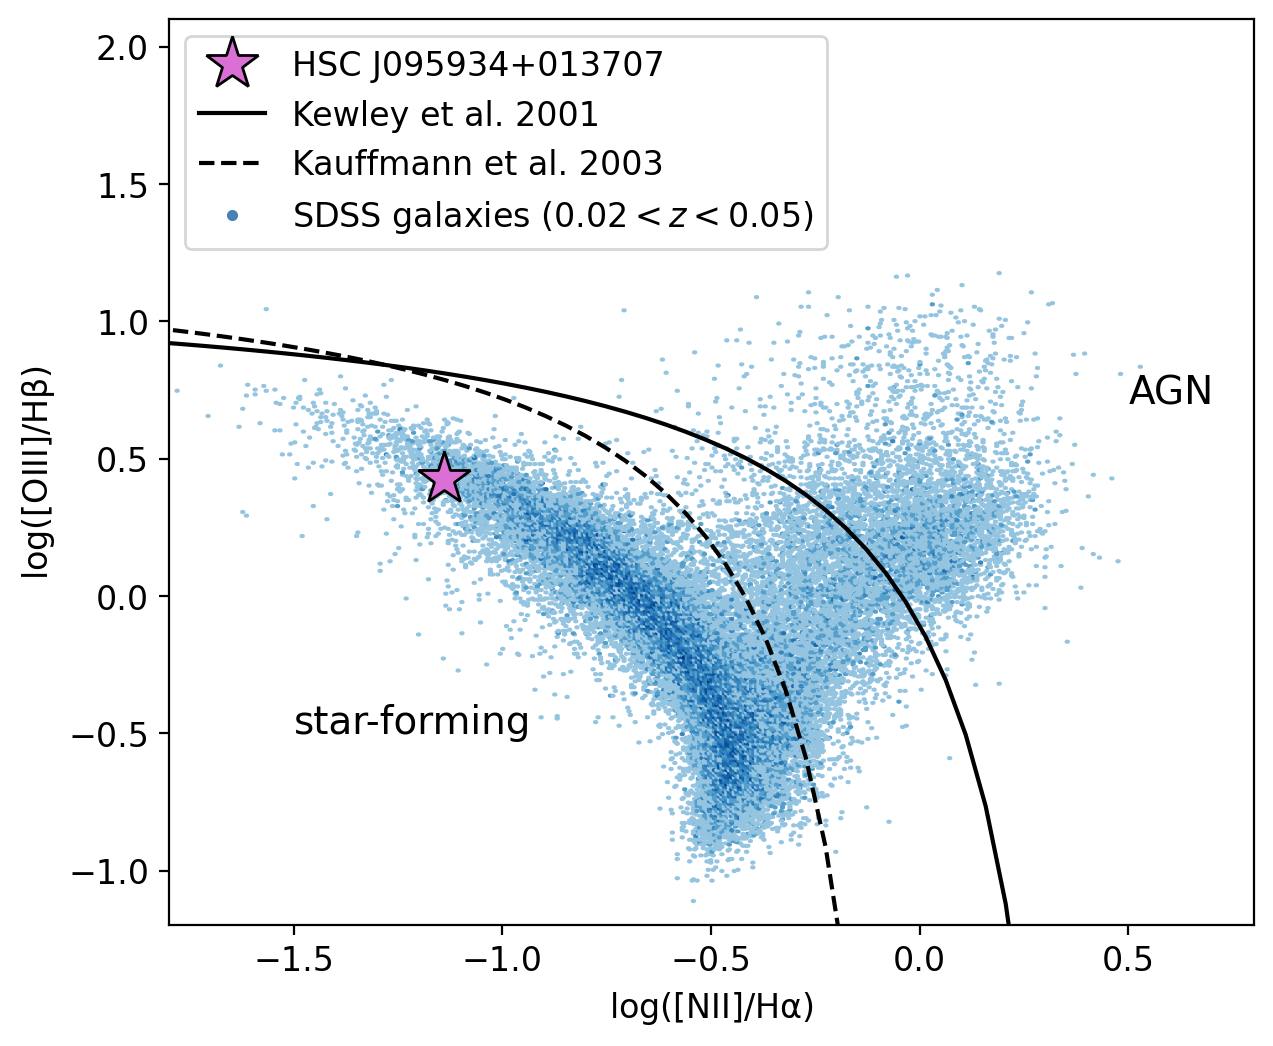

In [36]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(7,6))
ax = plt.gca()

plt.plot(fratio1, fratio2, marker='*', 
         color='orchid', markeredgecolor='black', markersize=20, ls='None', label='HSC J095934+013707')

NII = np.linspace(-2.0, 0.35)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k', label='Kewley et al. 2001')

ka03 = 0.61/(NII-0.05) + 1.3
idx = [i for i in range(len(NII)) if NII[i]<0 ]
plt.plot(NII[idx], ka03[idx], '--k', label='Kauffmann et al. 2003')

plt.xlim(-1.8, 0.8) 
plt.ylim(-1.2, 2.1)

handles, labels = ax.get_legend_handles_labels()
plt.hexbin(log_nII_ha_sdss, log_oIII_hb_sdss, cmap=cmap_blu, mincnt=1, gridsize=500, bins='log')
blue_point = matplotlib.lines.Line2D([], [], color='steelblue', marker='.', ls='None',
                          markersize=6, label=r'SDSS galaxies ($0.02<z<0.05$)')
handles.append(blue_point)
plt.legend(handles=handles, loc='upper left', **{'fontsize': 12})

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.text(0.5, 0.7, "AGN", fontsize=14)
plt.text(-1.5, -0.5, "star-forming", fontsize=14)

plt.savefig(f'{plot_dir}/bpt.png', bbox_inches='tight')

Now as 2 separate components:

In [37]:
# gaussian fluxes 
fratio1_left = np.log10(gflux_nII_left/gflux_halpha_left)
fratio2_left = np.log10(gflux_oIII_left/gflux_hbeta_left)

# gaussian fluxes 
fratio1_right = np.log10(gflux_nII_right/gflux_halpha_right)
fratio2_right = np.log10(gflux_oIII_right/gflux_hbeta_right)

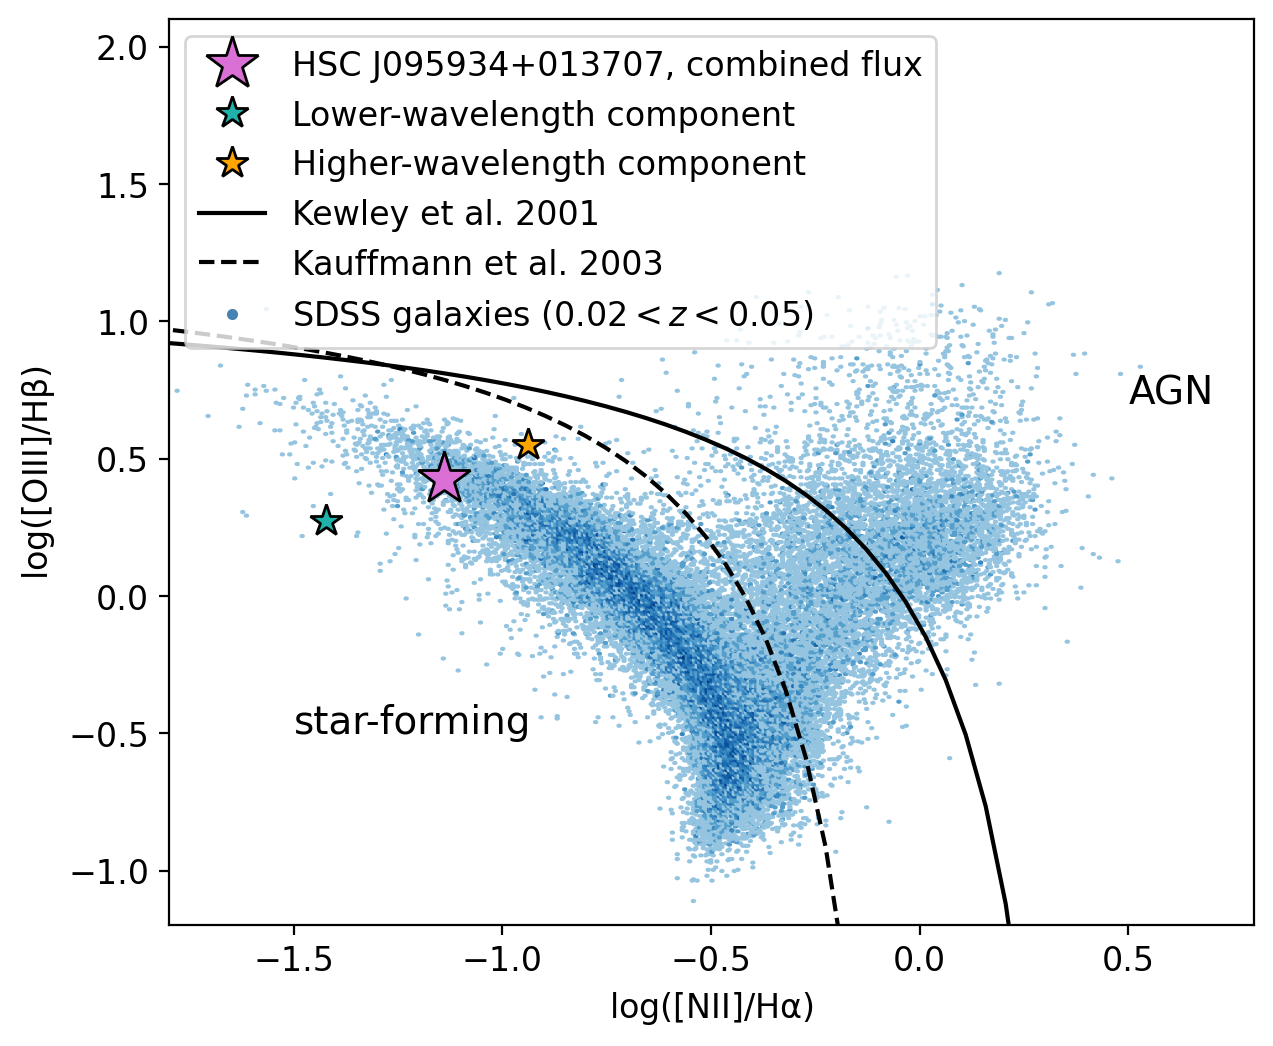

In [41]:
import numpy as np
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(7,6))
ax = plt.gca()

plt.plot(fratio1, fratio2, marker='*', 
         color='orchid', markeredgecolor='black', markersize=20, ls='None', label='HSC J095934+013707, combined flux')
plt.plot(fratio1_left, fratio2_left, marker='*', 
         color='lightseagreen', markeredgecolor='black', markersize=12, ls='None', label='Lower-wavelength component')
plt.plot(fratio1_right, fratio2_right, marker='*', 
         color='orange', markeredgecolor='black', markersize=12, ls='None', label='Higher-wavelength component')

NII = np.linspace(-2.0, 0.35)
plt.plot(NII, log_OIII_Hb_NII(NII), '-k', label='Kewley et al. 2001')

ka03 = 0.61/(NII-0.05) + 1.3
idx = [i for i in range(len(NII)) if NII[i]<0 ]
plt.plot(NII[idx], ka03[idx], '--k', label='Kauffmann et al. 2003')

plt.xlim(-1.8, 0.8) 
plt.ylim(-1.2, 2.1)

handles, labels = ax.get_legend_handles_labels()
plt.hexbin(log_nII_ha_sdss, log_oIII_hb_sdss, cmap=cmap_blu, mincnt=1, gridsize=500, bins='log')
blue_point = matplotlib.lines.Line2D([], [], color='steelblue', marker='.', ls='None',
                          markersize=6, label=r'SDSS galaxies ($0.02<z<0.05$)')
handles.append(blue_point)
plt.legend(handles=handles, loc='upper left', **{'fontsize': 12})

plt.xlabel(r'$\mathrm{log([NII]/H\alpha)}$', fontsize='large')
plt.ylabel(r'$\mathrm{log([OIII]/H\beta)}$', fontsize='large')
plt.text(0.5, 0.7, "AGN", fontsize=14)
plt.text(-1.5, -0.5, "star-forming", fontsize=14)

plt.savefig(f'{plot_dir}/bpt.png', bbox_inches='tight')

## Color-color diagram

Compute g-r and r-i colors for SDSS

In [42]:
gr_color_sdss = data_sdss['M_g_MODEL'] - data_sdss['M_r_MODEL']
ri_color_sdss = data_sdss['M_r_MODEL'] - data_sdss['M_i_MODEL']

Compute g-r and r-i colors for our object

In [43]:
info_fn = f'{base_dir}/data/hsc_catalogs/pdr2_wide_icmod_20.0-20.5_clean_more.csv'
cols = ['idx', 'ra_x', 'dec_x', 'object_id', 'g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag']
info_df = pd.read_csv(info_fn, usecols=cols, squeeze=False)
info_df = info_df.set_index('idx')
print("Read in info file {} with {} rows".format(info_fn, len(info_df)))

info_df.astype({"object_id": np.int64})

info_id = 936569 # ID of our object in the catalog 
info = info_df.loc[info_id]
print(f"Check RA and dec to make sure we have the correct object: {info['ra_x']}, {info['dec_x']}")

gmag = info['g_cmodel_mag']
rmag = info['r_cmodel_mag']
imag = info['i_cmodel_mag']

Read in info file /scratch/ksf293/anomalies/data/hsc_catalogs/pdr2_wide_icmod_20.0-20.5_clean_more.csv with 942781 rows
Check RA and dec to make sure we have the correct object: 149.89192988240174, 1.618810606548495


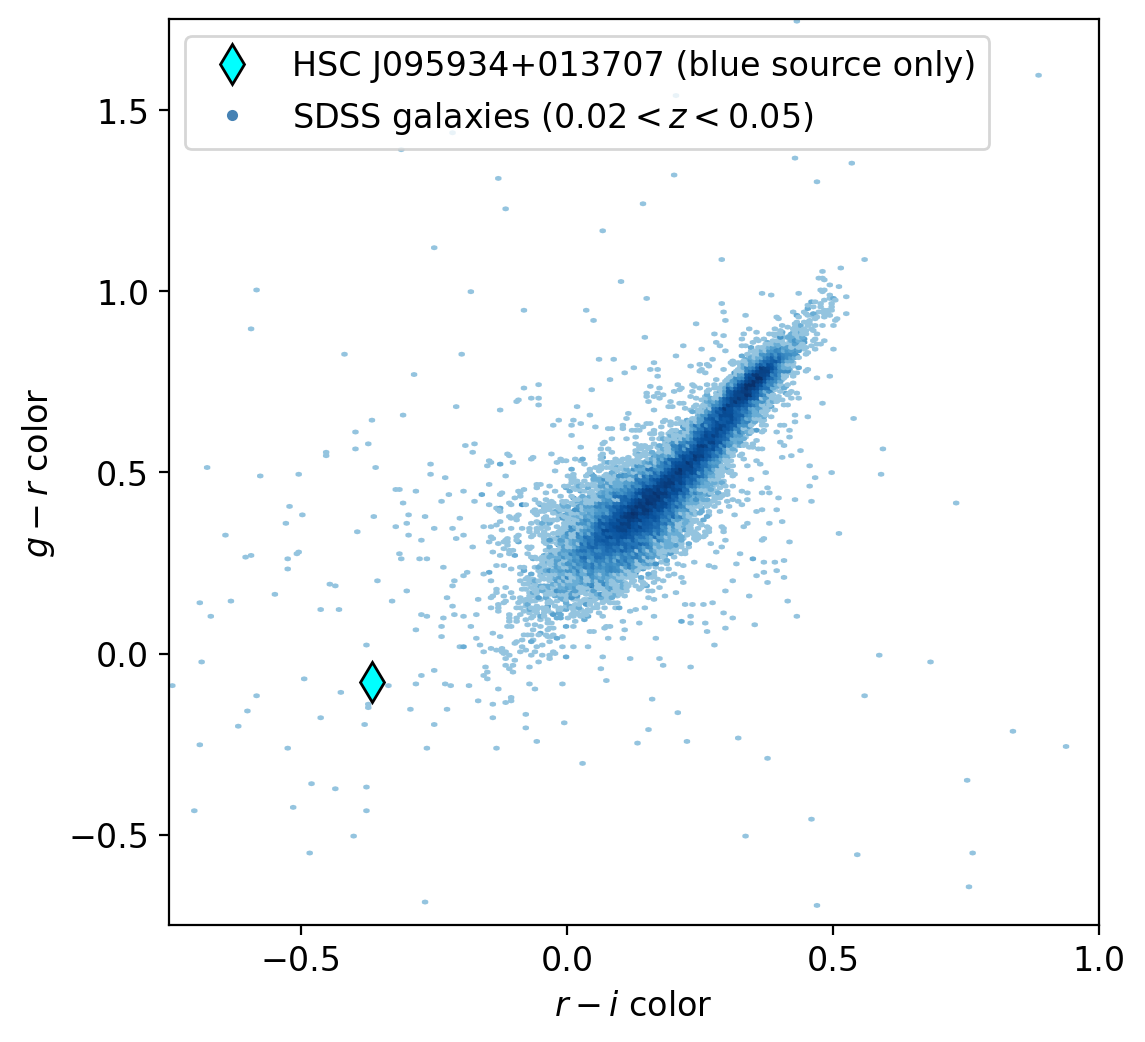

In [52]:
plt.figure(figsize=(6,6))
ax = plt.gca()
plt.plot(rmag-imag, gmag-rmag, marker='d', markeredgecolor='black', color='cyan', markersize=10, 
         label='HSC J095934+013707 (blue source only)', ls='None')

#plt.scatter(ri_color_sdss, gr_color_sdss,
#           c='teal', alpha=0.5, s=6, lw=0, label=r'SDSS galaxies ($0.02<z<0.05$)')
handles, labels = ax.get_legend_handles_labels()
plt.hexbin(ri_color_sdss, gr_color_sdss, cmap=cmap_blu, mincnt=1, gridsize=2500, bins='log')
blue_point = matplotlib.lines.Line2D([], [], color='steelblue', marker='.', ls='None',
                          markersize=6, label=r'SDSS galaxies ($0.02<z<0.05$)')
handles.append(blue_point)
plt.legend(handles=handles, loc='upper left', **{'fontsize': 12})

rimin, rimax = -0.75, 1.0
grmin, grmax = -0.75, 1.75 

ticks = np.arange(-2, 2, 0.5)
plt.xticks(ticks)
plt.yticks(ticks)
plt.xlim(rimin, rimax)
plt.ylim(grmin, grmax)

plt.xlabel(r"$r-i$ color")
plt.ylabel(r"$g-r$ color")
#plt.legend(loc='upper left')

plt.savefig(f'{plot_dir}/color-color.png', bbox_inches='tight')

## Metallicity measurments

_via yifei_ 

O3N2 = np.log10(OIII5007/Hbeta*Ha/NII6584)

metallicty_O3N2 = 8.505 - 0.221 * O3N2

N2 = np.log10(NII6584/Ha)

metallicty_N2 = 8.667 + 0.455 * N2

N2S2 = np.log10(NII6584/(SII6717+SII6731))

metallicty_N2S2 = 8.77 + N2S2 + 0.264 * N2


Previous (from yifei): 12+log(O/H) = 8.07 based on OIII5007 and NII6584, 12+log(O/H) =8.18 based on NII6584, and 12+log(O/H) = 7.91 based on NII6584, SII6717 and SII6731

In [45]:
O3N2 = np.log10(gflux_oIII/gflux_hbeta*gflux_halpha/gflux_nII)
metallicty_O3N2 = 8.505 - 0.221 * O3N2
print(f"metallicity O3N2, combined flux: {metallicty_O3N2:.3f}")

N2 = np.log10(gflux_nII/gflux_halpha)
metallicty_N2 = 8.667 + 0.455 * N2
print(f"metallicity N2, combined flux: {metallicty_N2:.3f}")

N2S2 = np.log10(gflux_nII/(gflux_sIIa+gflux_sIIb))
metallicty_N2S2 = 8.77 + N2S2 + 0.264 * N2
print(f"metallicity N2S2, combined flux: {metallicty_N2S2:.3f}")

metallicity O3N2, combined flux: 8.158
metallicity N2, combined flux: 8.148
metallicity N2S2, combined flux: 7.915


In [46]:
O3N2_left = np.log10(gflux_oIII_left/gflux_hbeta_left*gflux_halpha_left/gflux_nII_left)
metallicty_O3N2_left = 8.505 - 0.221 * O3N2_left
print(f"metallicity O3N2, bluer component: {metallicty_O3N2_left:.3f}")

N2_left = np.log10(gflux_nII_left/gflux_halpha_left)
metallicty_N2_left = 8.667 + 0.455 * N2_left
print(f"metallicity N2, bluer component: {metallicty_N2_left:.3f}")

N2S2_left = np.log10(gflux_nII_left/(gflux_sIIa_left+gflux_sIIb_left))
metallicty_N2S2_left = 8.77 + N2S2_left + 0.264 * N2_left
print(f"metallicity N2S2, bluer component: {metallicty_N2S2_left:.3f}")

metallicity O3N2, bluer component: 8.130
metallicity N2, bluer component: 8.020
metallicity N2S2, bluer component: 7.714


In [47]:
O3N2_right = np.log10(gflux_oIII_right/gflux_hbeta_right*gflux_halpha_right/gflux_nII_right)
metallicty_O3N2_right = 8.505 - 0.221 * O3N2_right
print(f"metallicity O3N2, redder component: {metallicty_O3N2_right:.3f}")

N2_right = np.log10(gflux_nII_right/gflux_halpha_right)
metallicty_N2_right = 8.667 + 0.455 * N2_right
print(f"metallicity N2, redder component: {metallicty_N2_right:.3f}")

N2S2_right = np.log10(gflux_nII_right/(gflux_sIIa_right+gflux_sIIb_right))
metallicty_N2S2_right = 8.77 + N2S2_right + 0.264 * N2_right
print(f"metallicity N2S2, redder component: {metallicty_N2S2_right:.3f}")

metallicity O3N2, redder component: 8.176
metallicity N2, redder component: 8.239
metallicity N2S2, redder component: 8.032


### sSFR measurement

SSFR=1.55*log10(EW(Halpha)-12

In [48]:
line = r'H$\alpha$'
region_width = 12.0
wmin = (line_dict[line]-region_width/2)*u.AA
wmax = (line_dict[line]+region_width/2)*u.AA

# spec_norm_cont is normalized to zero, make it 1 for EW measurement
spec_norm_cont_1 = spec_norm_cont + 1.0
ew_halpha = equivalent_width(spec_norm_cont_1, regions=SpectralRegion(wmin, wmax), continuum=1.0)
# use absolute value for emission (https://en.wikipedia.org/wiki/Equivalent_width)
ew_halpha = abs(ew_halpha)


/ext3/miniconda3/envs/anomenv/lib/python3.8/site-packages/scipy/interpolate/interpolate.py:2559: RuntimeWarning: invalid value encountered in true_divide
  norm_distances.append((x - grid[i]) /


In [49]:
ssfr = 1.55*np.log10(ew_halpha.value - 12)
print(f"Halpha EW: {ew_halpha:.3f}")
print(f"sSFR: {ssfr:.3f}")

Halpha EW: 86.319 Angstrom
sSFR: 2.900
